## Compare if we get more information from which columns


In [53]:
from models.ICA_EM import *
from models.dgp import *
from models.metrics import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib, sys
importlib.reload(sys.modules['models.dgp'])
importlib.reload(sys.modules['models.metrics'])
importlib.reload(sys.modules['models.ICA_EM'])
import tqdm
from sklearn.metrics import mean_squared_error as mse

In [3]:
n = 10000
J = 6
I = 5

In [5]:
def percentage_first_column_is_better(treatment_true, treatment_first, treatment_third):
    # requires numpy arrays

    deviation_first = np.abs(treatment_first - treatment_true)
    deviation_third = np.abs(treatment_third - treatment_true)
    return np.sum(deviation_first < deviation_third)/len(deviation_first)
    

## 3 modes: 1. No Enforcement of Zeors, 2 enforcement of only pre treatment controlls, 3 enforcement of assumed known DAG

By construction of the DAG the true mixing matrix is already lower triangular


### Mode 1 No Enforcement of Zeors

In [34]:
def sim(mode, B, iter):
    B = B
    df = pd.DataFrame(data = np.zeros((B, 7)), columns=["true_treatment", "first", "second", "third", "fourth", "fifth", "sixth"])
    # fifth should correspond to the true treatment
    data = dgp(noise_dict= {"loc" : 0, "scale" : 0}, prior= {"loc" : 0, "scale" : 1/np.sqrt(2)})
    for i in tqdm.tqdm(range(B)):
        data.generate_data(n,I, J, random_state=i)
        est = CausalVarEM(update_sigma=False, true_A=None, max_iter = iter, random_seed= i, mode=mode)
        est.fit(data.data_observed,J, noise_params= {"mean" : 0, "std" : 1}, progress_bar=False)
        df.iloc[i, 0] = data.treatment_effect
        df.iloc[i, 1:] =  est.A[-1,:]
    return df


def metrics(df):
    # mse for all columns
    true_treatment = df["true_treatment"]
    for i in range(1,6):
        mse_column = mse(true_treatment, df.iloc[:,i])
        print("MSE for column " + str(i) + " is " + str(mse_column))
        print("Standard deviation for column " + str(i) + " is " + str(np.std(df.iloc[:,i])))

In [17]:
df = sim("each", 100, 100)
df.to_csv("results/CausalVarEM_each_all_columns.csv", index=False)


100%|██████████| 100/100 [37:20<00:00, 22.40s/it]


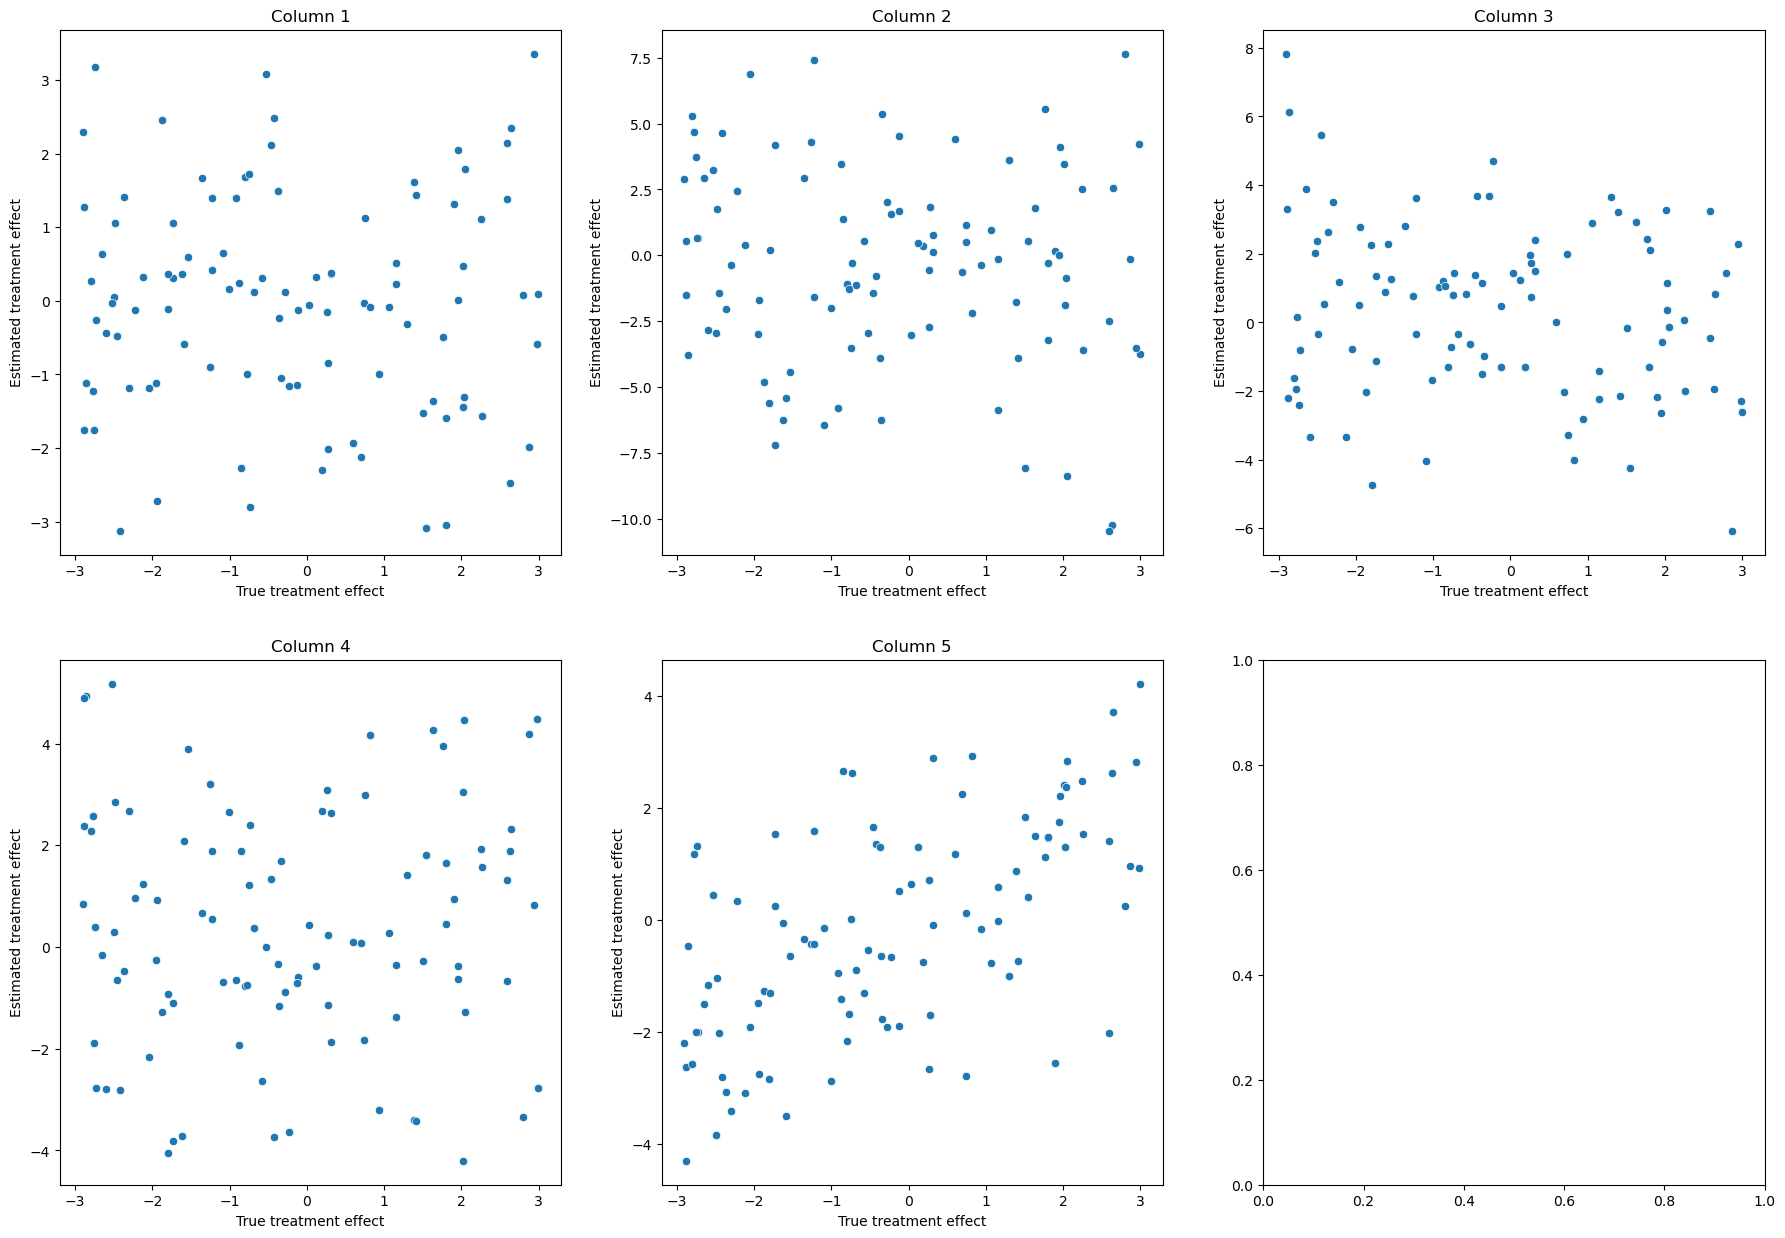

In [24]:
df = pd.read_csv("results/CausalVarEM_each_all_columns.csv")

fig, ax = plt.subplots(2,3, figsize = (22,15))
# plot the true treatment effect vs all columns
for i in range(1,6):
    sns.scatterplot(x = "true_treatment", y = df.columns[i], data = df, ax = ax[int((i-1)/3), (i-1)%3])
    ax[int((i-1)/3), (i-1)%3].set_title("Column " + str(i))
    ax[int((i-1)/3), (i-1)%3].set_xlabel("True treatment effect")
    ax[int((i-1)/3), (i-1)%3].set_ylabel("Estimated treatment effect")


In [26]:
metrics(df)

MSE for column 1 is 5.506085637668949
Standard deviation for column 1 is 1.4700387167853628
MSE for column 2 is 18.931560945505137
Standard deviation for column 2 is 3.7573010694686158
MSE for column 3 is 11.447256943384835
Standard deviation for column 3 is 2.4810259311883316
MSE for column 4 is 8.662083155882065
Standard deviation for column 4 is 2.3265459832392947
MSE for column 5 is 2.7492643608486276
Standard deviation for column 5 is 1.8995353587520662


### Mode 2 enforcement of only pre treatment controlls

In [33]:
df = sim("pre_treatment_controlls", 100, 100)
df.to_csv("results/CausalVarEM_pre_treatment_controlls_all_columns.csv", index=False)


100%|██████████| 100/100 [37:43<00:00, 22.63s/it]


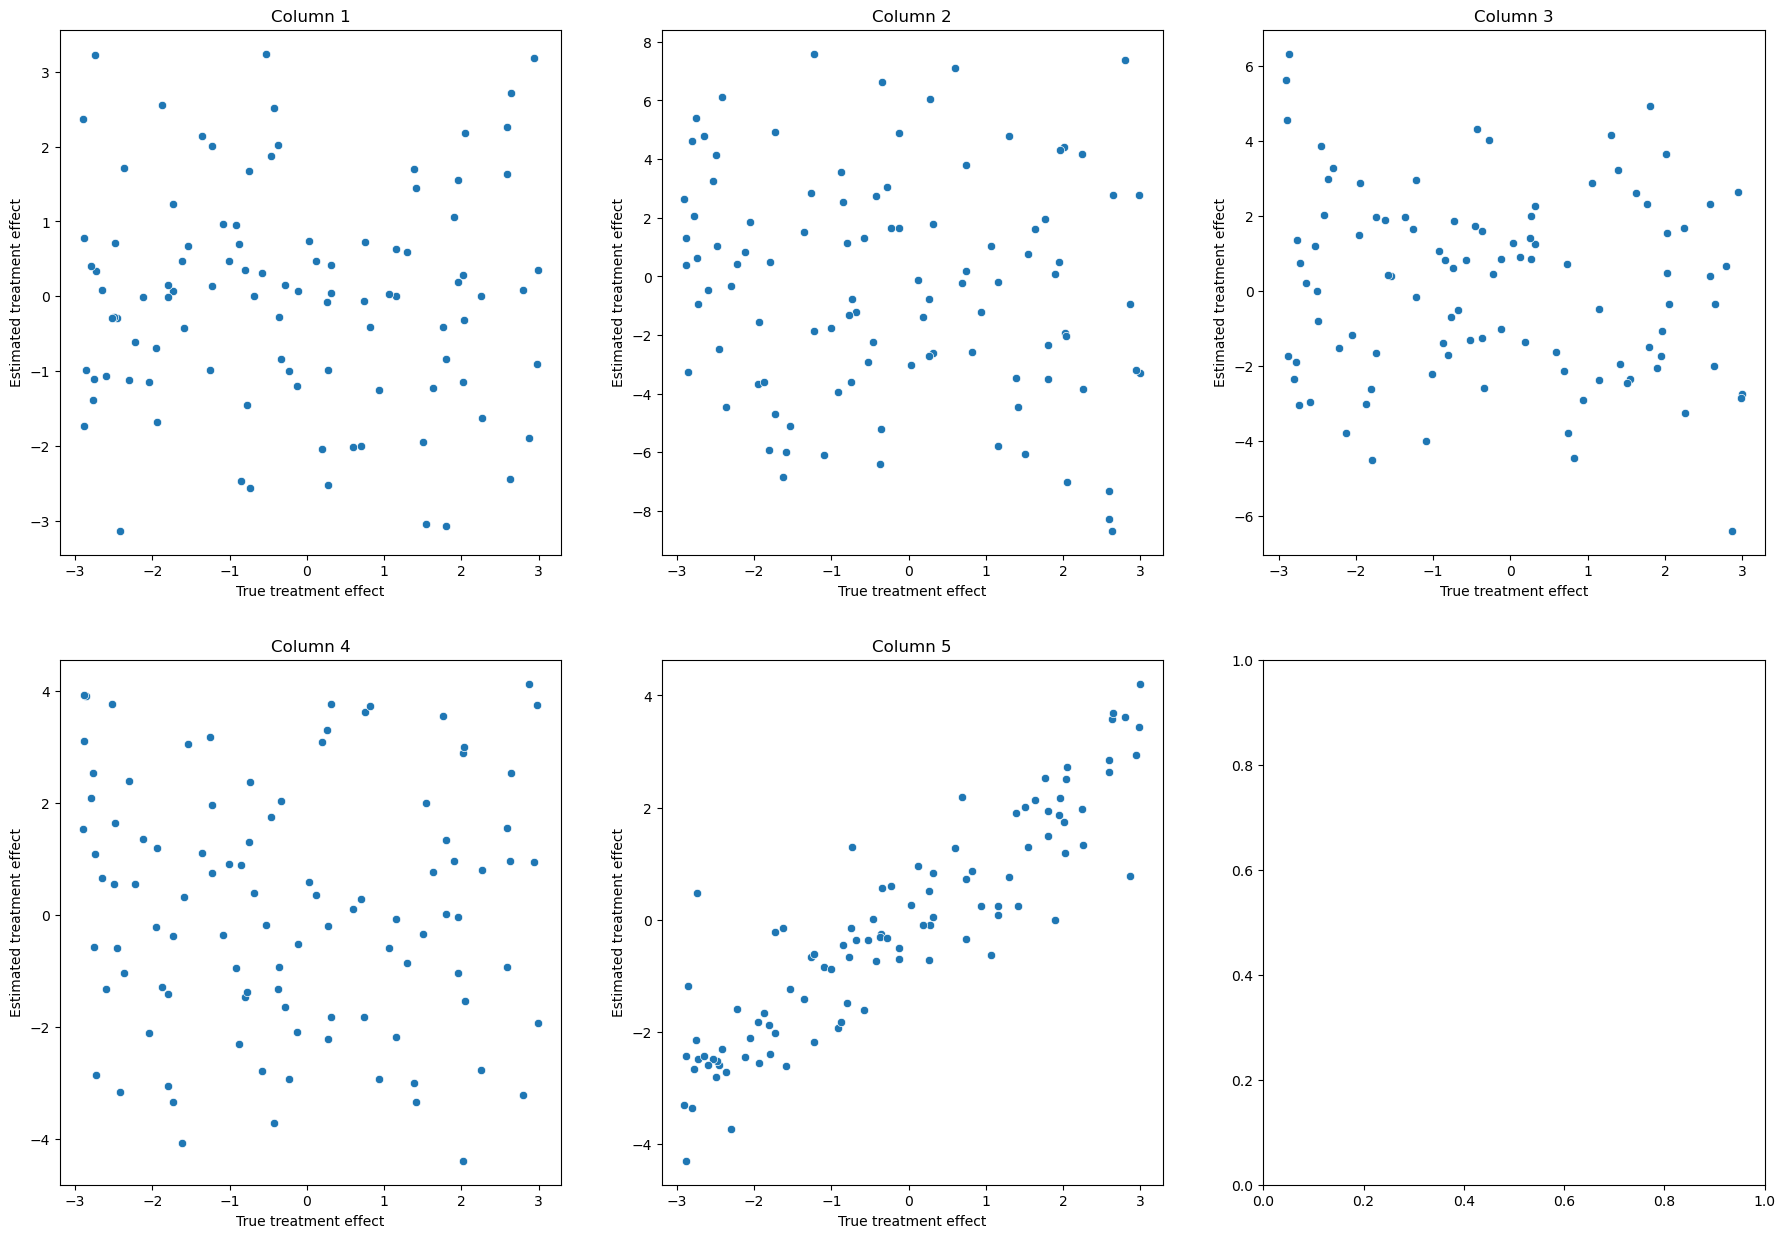

In [43]:
df = pd.read_csv("results/CausalVarEM_pre_treatment_controlls_all_columns.csv")

fig, ax = plt.subplots(2,3, figsize = (22,15))
# plot the true treatment effect vs all columns
for i in range(1,6):
    sns.scatterplot(x = "true_treatment", y = df.columns[i], data = df, ax = ax[int((i-1)/3), (i-1)%3])
    ax[int((i-1)/3), (i-1)%3].set_title("Column " + str(i))
    ax[int((i-1)/3), (i-1)%3].set_xlabel("True treatment effect")
    ax[int((i-1)/3), (i-1)%3].set_ylabel("Estimated treatment effect")


In [36]:
metrics(df) 

MSE for column 1 is 5.43890388873313
Standard deviation for column 1 is 1.4593073331891628
MSE for column 2 is 19.64005603867503
Standard deviation for column 2 is 3.8056866380119923
MSE for column 3 is 10.597607388896975
Standard deviation for column 3 is 2.4811092339459018
MSE for column 4 is 8.330564846853092
Standard deviation for column 4 is 2.1721918237914526
MSE for column 5 is 0.676631901193408
Standard deviation for column 5 is 1.9102204449111138


### 3 enforcement of assumed known DAG

In [54]:
df = sim("lower_triangular", 100, 100)
df.to_csv("results/CausalVarEM_lower_triangular_all_columns.csv", index=False)


100%|██████████| 100/100 [37:05<00:00, 22.26s/it]


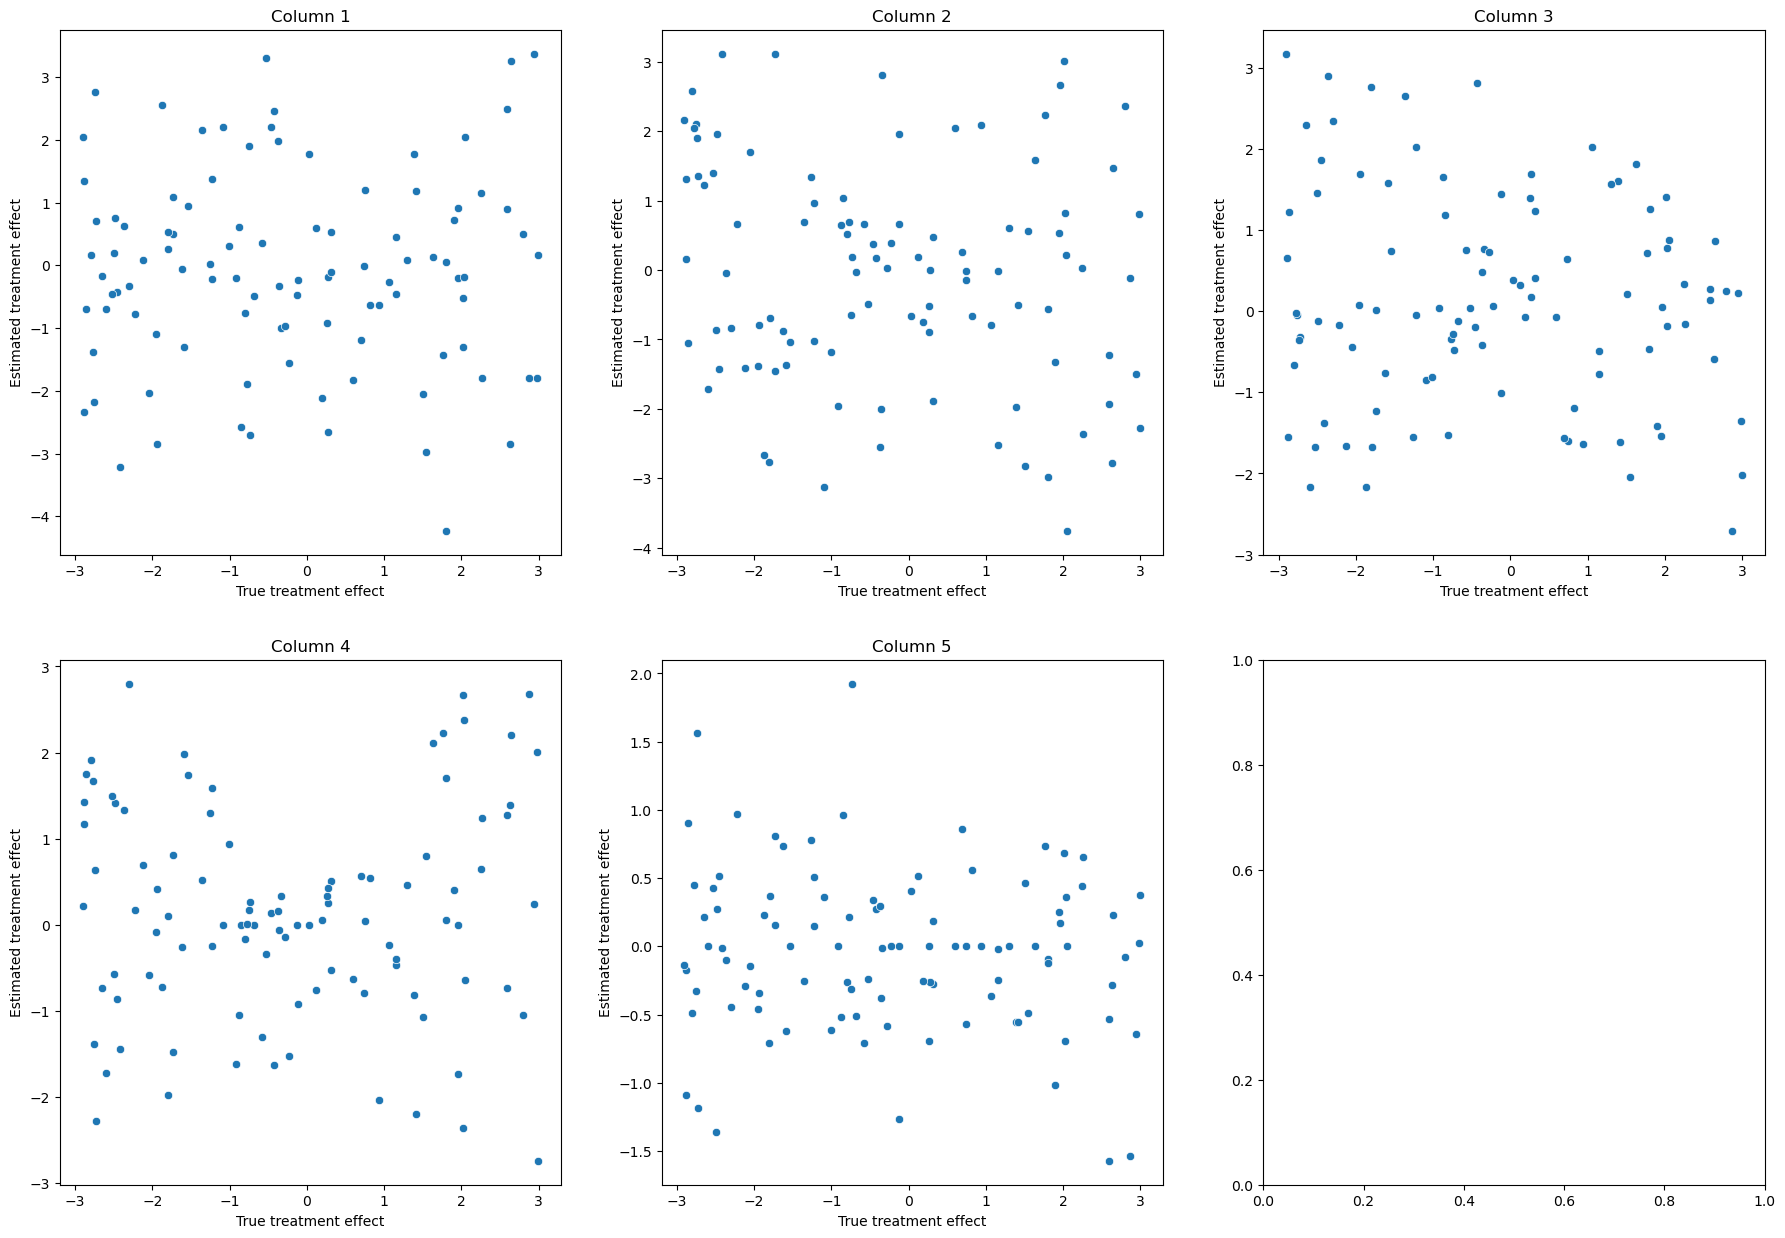

In [56]:
df = pd.read_csv("results/CausalVarEM_lower_triangular_all_columns.csv")

fig, ax = plt.subplots(2,3, figsize = (22,15))
# plot the true treatment effect vs all columns
for i in range(1,6):
    sns.scatterplot(x = "true_treatment", y = df.columns[i], data = df, ax = ax[int((i-1)/3), (i-1)%3])
    ax[int((i-1)/3), (i-1)%3].set_title("Column " + str(i))
    ax[int((i-1)/3), (i-1)%3].set_xlabel("True treatment effect")
    ax[int((i-1)/3), (i-1)%3].set_ylabel("Estimated treatment effect")

In [46]:
metrics(df) 

MSE for column 1 is 5.649417749308093
Standard deviation for column 1 is 1.5656966013296771
MSE for column 2 is 6.753241647507424
Standard deviation for column 2 is 1.5949018517039137
MSE for column 3 is 5.613242132506882
Standard deviation for column 3 is 1.3037613578209182
MSE for column 4 is 4.718957749390928
Standard deviation for column 4 is 1.2343399002865398
MSE for column 5 is 3.8131802278734677
Standard deviation for column 5 is 0.594759278284876


## Better plots

In [47]:
def vioplot(data):
    df = data.copy().drop("sixth", axis = 1)
    df["id"] = range(len(df))
    df_long = df.melt(id_vars = ["id"])
    plt.figure(figsize=(12,5))
    sns.violinplot(data = df_long,x = "variable",  y = "value" , alpha = 0.5)
    plt.xlabel("Column")
    plt.ylabel("Treatment effect")
    plt.title("Violin plot of estimated treatment effects")
    plt.show()


In [48]:
df_no_zeros = pd.read_csv("results/CausalVarEM_each_all_columns.csv")

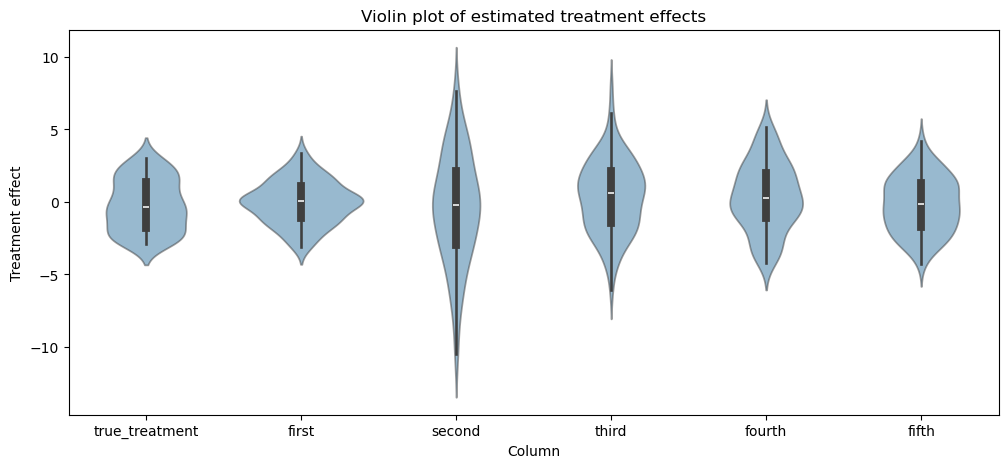

In [49]:
vioplot(df_no_zeros)


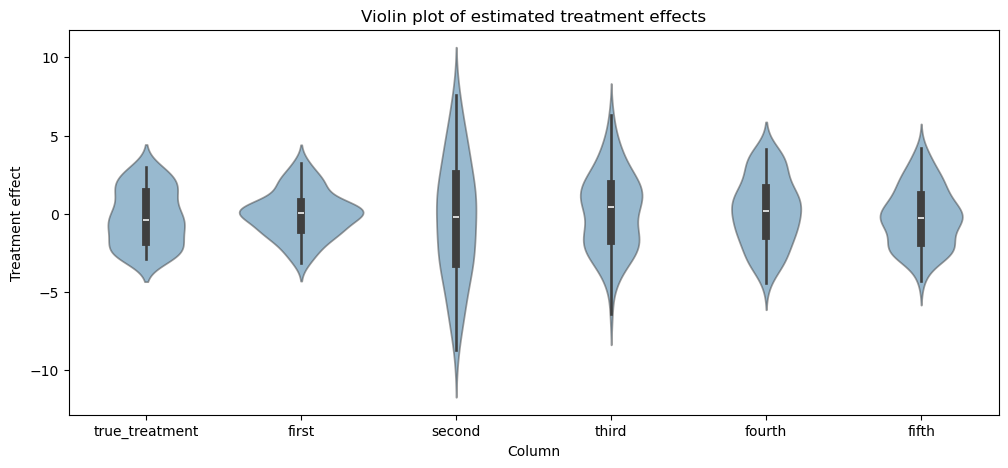

In [50]:
df_pre_treatment_controlls = pd.read_csv("results/CausalVarEM_pre_treatment_controlls_all_columns.csv")
vioplot(df_pre_treatment_controlls)

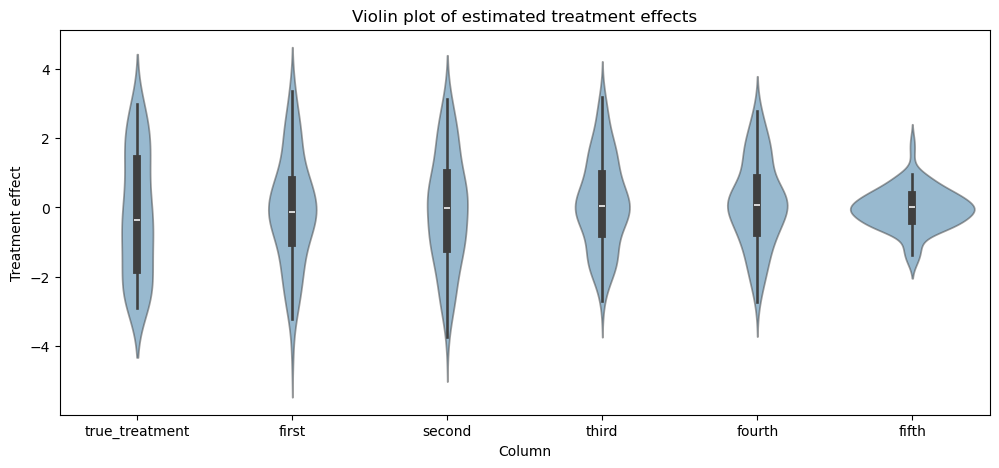

In [51]:
df_lower_triangular = pd.read_csv("results/CausalVarEM_lower_triangular_all_columns.csv")
vioplot(df_lower_triangular)